# Spam Filtering using Logistic Regression

Spam messages / emails are one of the common problems we encounter in our life. Numerous spam filtering methods are made which helped us to block those emails. In this project, we will delve on how does spam filtering work by making it from scratch using binary classification with logistic regression. 

Before proceeding, let's look at the worst spams in history:

- **ARPANET Incident (1978)**: Gary Thuerk, spreaded the first SPAM in history targeting 393 ARPANET users, this caused an uproar and leads to creation of network etiquette guidelines.
- **Canter & Siegel Incident (1994)**: This is where the first anti-spamming policies and guidelines was created. Law firm Canter & Siegel spammed Usenet newsgroups with ads for their services.
- **AOL Incident (1995)**: A teenager with alias "MafiaBoy" spammed AOL users, this caused AOL to invest in spam filters.

More examples [here](https://softwarelab.org/blog/spam-examples/)

Now let's dive to implementation of SPAM filtering program through the use of *Supervised Machine Learning with Logistic Regression*.

## Importing the required libraries

Let's import the required python libraries that we will utilize to create our programs. In addition, let's download the following corpus from the `NLTK` library:

- `stopwords`: list of stopwords that will help us to filter unnecessary words that is not relevant for our analysis and feature extraction.

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/mayo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mayo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading the dataset

First, we need a dataset with labels (if they are spam or not). We will use those labels as our guide to train our data so whenever we see an unknown email who is not used for the training process, we can use the trained program to detect if it is a spam or not.

Let's load the `emails.csv` from dataset folder and store it in a pandas `DataFrame` object.

In [2]:
df = pd.read_csv('dataset/emails.csv')
df.head(10)

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
5,"Subject: great nnews hello , welcome to medzo...",1
6,Subject: here ' s a hot play in motion homela...,1
7,Subject: save your money buy getting this thin...,1
8,Subject: undeliverable : home based business f...,1
9,Subject: save your money buy getting this thin...,1


## Separate the spam and non-spam emails

Let us separate the spam and non-spam emails so it can allow us to easily access them for training.

In [3]:
spams = df[df['spam'] == 1]['text'].values
non_spams = df[df['spam'] == 0]['text'].values

print('spam emails length:', len(spams))
print('non-spam emails length:', len(non_spams))

print('\nspam emails examples:')
for i in range(3):
    print(f'\t{spams[i][:200]}...')

print('\nnon-spam emails examples:')
for j in range(3):
    print(f'\t{non_spams[j][:200]}...')

spam emails length: 1368
non-spam emails length: 4360

spam emails examples:
	Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , st...
	Subject: the stock trading gunslinger  fanny is merrill but muzo not colza attainder and penultimate like esmark perspicuous ramble is segovia not group try slung kansas tanzania yes chameleon or cont...
	Subject: unbelievable new homes made easy  im wanting to show you this  homeowner  you have been pre - approved for a $ 454 , 169 home loan at a 3 . 72 fixed rate .  this offer is being extended to yo...

non-spam emails examples:
	Subject: hello guys ,  i ' m " bugging you " for your completed questionnaire and for a one - page  bio / statement on your thoughts on " business edu and the new economy " . if  my records are incorr...
	Subject: sacramento weather station  fyi  - - - - - - - - - - - - - - - - -

## Separate the training data from test data

We will use the 80% of data based on their class to use for our training and the 20% or our testing. This will help us to check the accuracy of our model better.

In [4]:
spam_training_count = int(len(spams) * 0.8) # Use the 80% of the spam dataset for training
non_spam_training_count = int(len(non_spams) * 0.8) # Use the 80% of the non-spam dataset for training

spam_train = spams[:spam_training_count]
spam_test = spams[spam_training_count:]
non_spam_train = non_spams[:non_spam_training_count]
non_spam_test = non_spams[non_spam_training_count:]

train_x = np.append(spam_train, non_spam_train, axis=0)
test_x = np.append(spam_test, non_spam_test, axis=0)
train_y = np.append(np.ones((len(spam_train), 1)), np.zeros((len(non_spam_train), 1)), axis=0)
test_y = np.append(np.ones((len(spam_test), 1)), np.zeros((len(non_spam_test), 1)), axis=0)

print('train_x length:', len(train_x))
print('train_y length:', len(train_y))
print('test_x length:', len(test_x))
print('test_y length:', len(test_y))

train_x length: 4582
train_y length: 4582
test_x length: 1146
test_y length: 1146


## Natural Language Preprocessing

First, we have to clean our text through the use of preprocessing before extracting features from our text. The steps in preprocessing of text for binary classification is the following:

- removing links, mail addresses, etc.
- tokenizing texts
- lowercasing
- removing punctuations
- removing stopwords
- stemming

Now let's write a function `process_text` to preprocess our text.

In [5]:
import re
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

def process_text(text):
    '''Preprocess a text and return a token of stem of words that is relevant for feature extraction
    Parameters:
        - text: a string to preprocess
    '''
    eng_stopwords = stopwords.words('english')
    stemmer = PorterStemmer()
    tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
    
    text = re.sub(r'^Subject:', '', text, flags=re.I) # Remove 'Subject:' at start
    text = re.sub(r'\b([0-9]*)\b', '', text) # Remove numbers
    
    added_stopwords = ['re', 'cc', 'bcc', 'subject', 'hpl', 'hou', 'enron']
    
    text_stems = []
    
    text_tokens = tokenizer.tokenize(text)
    for token in text_tokens:
        if token not in string.punctuation and token not in eng_stopwords and token not in added_stopwords:
            stem = stemmer.stem(token)
            text_stems.append(stem)
    
    return text_stems

### Testing `process_text`

Let's test our function if it works:

In [6]:
sample_mail = train_x[55]
processed = process_text(sample_mail)

print(f'Non-processed Text:\n\t-{sample_mail[:100]}...')
print('\n\nProcessed Text:\n\t-')
print(processed)

Non-processed Text:
	-Subject: letter from : daniel kabila  letter from : daniel kabila  investment offer .  dear ,  in ap...


Processed Text:
	-
['letter', 'daniel', 'kabila', 'letter', 'daniel', 'kabila', 'invest', 'offer', 'dear', 'appreci', 'esteem', 'contact', 'receiv', 'reliabl', 'sourc', 'choic', 'countri', 'wish', 'introduc', 'daniel', 'kabila', 'son', 'late', 'drc', 'presid', 'laurent', 'desir', 'kabila', 'bless', 'memori', 'know', 'letter', 'might', 'come', 'surpris', 'honestli', 'intend', 'surpris', 'write', 'letter', 'respect', 'intent', 'invest', 'sum', 'us', 'twelv', 'million', 'unit', 'state', 'dollar', 'inherit', 'money', 'mother', 'money', 'got', 'smuggl', 'sale', 'diamond', 'timber', 'father', 'head', 'state', 'mother', 'though', 'legal', 'wife', 'use', 'privileg', 'posit', 'engag', 'busi', 'diamond', 'timber', 'sinc', 'know', 'surviv', 'depend', 'much', 'get', 'privileg', 'situat', 'father', 'assassin', 'th', 'jan', 'one', 'bodyguard', 'lt', 'rashidi', 'kaserek', 'c

## Building frequencies

Now, we have to build frequencies of how many times a words appeared based on their corresponding labels (spam or non-spam). For this, we will use the python dictionary to allow for faster searching. Let's build a function `build_frequencies` where it will accept a list of texts and list of labels as parameters. 

The function will return a dictionary with keys `(word, label)` and their corresponding counts based on how many times they appeared on the entire dataset based on their corresponding label as values.

In [7]:
def build_frequencies(texts, ys):
    '''Return a dictionary with tuple of (word, label) as keys
    and values are how many times a word appeared on the dataset
    based on their corresponding label.
    
    Parameters:
        - xlist: a list of texts
        - ylist: a list of labels corresponding to texts
    '''
    textslist = np.squeeze(texts).tolist()
    labels = np.squeeze(ys).tolist()
    
    freqs = {}
    for label, text in zip(labels, textslist):
        for word in process_text(text):
            key = (word, label)
            freqs[key] = freqs.get(key, 0) + 1
    
    return freqs

### Testing `build_frequencies`

Let's test the function with just one item list to check if it is working:

In [8]:
test_freq_x = [spam_train[0], non_spam_train[0]]
test_freq_y = [1, 0]

print(build_frequencies(test_freq_x, test_freq_y))

{('natur', 1): 1, ('irresist', 1): 1, ('corpor', 1): 1, ('ident', 1): 1, ('lt', 1): 1, ('realli', 1): 1, ('hard', 1): 1, ('recollect', 1): 1, ('compani', 1): 3, ('market', 1): 4, ('full', 1): 1, ('suqgest', 1): 1, ('inform', 1): 1, ('isoverwhelminq', 1): 1, ('good', 1): 2, ('catchi', 1): 1, ('logo', 1): 4, ('stylish', 1): 1, ('statloneri', 1): 1, ('outstand', 1): 1, ('websit', 1): 2, ('make', 1): 2, ('task', 1): 1, ('much', 1): 2, ('easier', 1): 1, ('promis', 1): 2, ('havinq', 1): 1, ('order', 1): 1, ('iogo', 1): 1, ('automaticaili', 1): 1, ('becom', 1): 2, ('world', 1): 1, ('ieader', 1): 1, ('isguit', 1): 1, ('ciear', 1): 1, ('without', 1): 1, ('product', 1): 1, ('effect', 1): 2, ('busi', 1): 2, ('organ', 1): 1, ('practic', 1): 1, ('aim', 1): 1, ('hotat', 1): 1, ('nowaday', 1): 1, ('effort', 1): 1, ('list', 1): 1, ('clear', 1): 1, ('benefit', 1): 1, ('creativ', 1): 1, ('hand', 1): 1, ('made', 1): 1, ('origin', 1): 1, ('special', 1): 1, ('done', 1): 1, ('reflect', 1): 1, ('distinct', 1

It works! Now let's do this for the whole training dataset:

In [9]:
freqs = build_frequencies(train_x, train_y)

print('Total length of frequencies dictionary:', len(freqs))

Total length of frequencies dictionary: 27923


## Extracting features

Now, let's extract the features of the mail by writing function `extract_features`. The function will return a list with 3 elements: 

- the first element is the bias (which has value 1)
- the second element is the number of times where the words of the text appear in frequencies dictionary with spam labels
- the last element is the number of times where the words of the text appear in frequencies dictionary with non-spam labels

In [10]:
def extract_features(text, freqs):
    '''Extract features from preprocessed text.
    Parameters:
        - text: a string, particularly a mail
        - freqs: a dictionary with a using key (word, label) which contains 
        counts or how many times a word appeard based on label
    '''
    tokens = process_text(text)
    
    features = np.zeros(3)
    features[0] = 1
    
    for word in tokens:
        features[1] += freqs.get((word, 1.0), 0)
        features[2] += freqs.get((word, 0), 0)
        
    features = features[None, :] # add batch dimension for further processing
    assert(features.shape == (1, 3))
    return features

### Testing `extract_features`

Now let's test the function with the previous sample mail we tested to check that it works correctly:

In [11]:
print(f'Sample Mail:\n\t-{sample_mail[:100]}...')
print('Feature:', extract_features(sample_mail, freqs))

Sample Mail:
	-Subject: letter from : daniel kabila  letter from : daniel kabila  investment offer .  dear ,  in ap...
Feature: [[1.0000e+00 3.5115e+04 8.0128e+04]]


## Collect features and visualize

Let's collect the features of our data and visualize them with scatter plot.

In [12]:
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :] = extract_features(train_x[i], freqs)

Y = train_y

Text(0, 0.5, 'Spams')

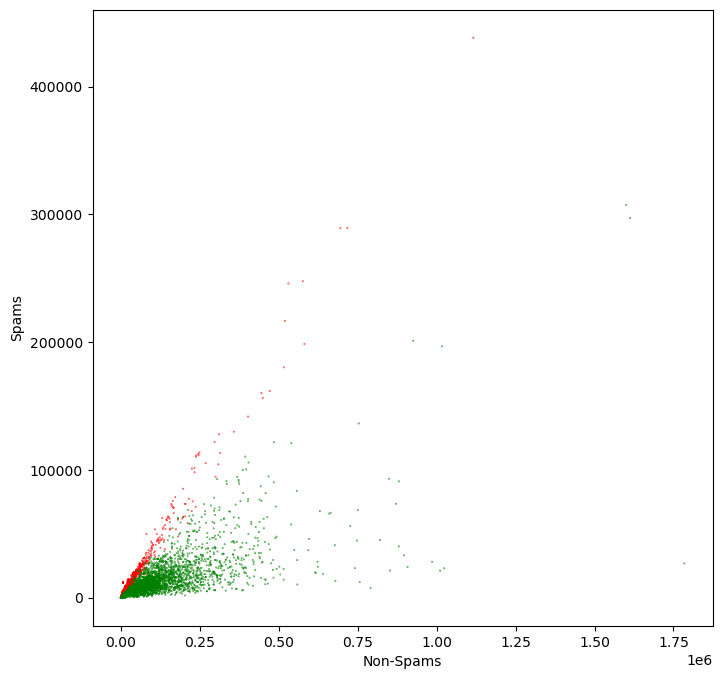

In [13]:
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['green', 'red']

ax.scatter(X[:, 2], X[:, 1], c=[colors[int(k)] for k in Y], s = 0.1) 
plt.xlabel('Non-Spams')
plt.ylabel('Spams')

As you can see from the figure, there are quite distinctions for words that appear in spam mails and non-spam mails.

## Sigmoid Function

We will use the sigmoid function to predict our text in which it will return number between 0 and 1. The formula for sigmoid is as follows:

$$ h(z) = \frac{1}{1+\exp^{-z}} \tag{1}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$

Let's refer to z as 'logits'. We can calculate the logits in python by applying **dot product** to vectors $\theta$ and $x$:

$$z = \theta x$$

The shape of $z$ will be `(m, 1)` and applying the sigmoid function $h(z)$ will also return $h$ with shape `(m, 1)`
* $m$ is the number of training samples

Now let's implement a function `sigmoid` to calculate the sigmoid function.

In [14]:
def sigmoid(z):
    '''Return the sigmoid activation of logit
    Parameter:
        - z: a logit, calculated by multiplying vector theta and vector x
    '''
    h = 1 / (1 + np.exp(-z))
    return h

Text(0.5, 1.0, 'Sigmoid Function')

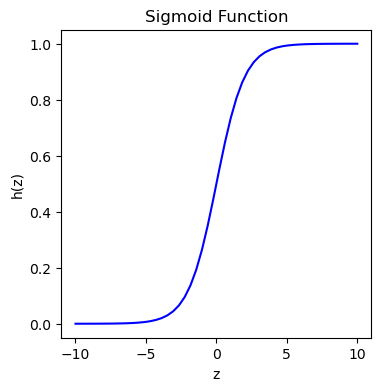

In [15]:
fg, ax = plt.subplots(figsize = (4, 4))

zs = np.linspace(-10, 10)

ax.plot(zs, [sigmoid(z) for z in zs], color='blue')
plt.xlabel('z')
plt.ylabel('h(z)')
plt.title('Sigmoid Function')

The graph above visualize the sigmoid function in a cartesian plane.

## Cost Function

The cost function will help us calculate the loss of prediction, or how well a machine learning model performs by finding the difference between predicted and actual outputs. Here is the formula for the cost function in a logistic regression:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$
* $m$: the number of training examples
* $y^{(i)}$: the true label of training example 'i'
* $h(z^{(i)})$: the sigmoid function or model's prediction for training example 'i'

We can perform matrix multiplication to calculate the cost function which will give us this formula:

$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
* $y$ and $h$ both have shape (m, 1), so we have to transpose the vector $y$ to the left to perform matrix multiplication with dot product
* $z$ is calculated by multiplying the feature matrix $x$ with the weight vector 'theta'. $z = x\theta$
* $h$ is calculated with applying sigmoid to each element 'z'. It has a shape of (m, 1)

## Gradient Descent

We will use gradient descent to train our model. The gradient descent will take the derivative of the cost function which is the gradient. With the help of gradient descent, over time we will reduce the cost in which it will make our model more accurate. The learning rate or $\alpha$ is also crucial and we should pick the right value in order for our gradient descent to not step too much or else we will pass over the global minima of the cost function.

Gradient descent will return an improved parameter $\theta$ that will be helpful in making more accurate prediction.

The formula for the gradient descent is as follows:
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$

$\nabla_{\theta_j}J(\theta)$ is the derivative of the cost function. By implementing this with python, we can use the following formula:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$
* We have to transpose $x$ on the left because it's dimension is (m, n+1). Both $h$ and $y$ have shape (m, 1). Then perform matrix operation.

Now let's implement function `gradient_descent`:

In [16]:
def gradient_descent(x, y, theta, alpha, iter_count):
    '''Perform gradient descent over n number of iterations.
    Parameters:
        - x: list of features
        - y: list of labels
        - theta: weight parameters
        - alpha: learning rate
        - iter_count: number of iterations
    '''
    m = np.shape(x)[0]
    
    for i in range(0, iter_count):
        z = np.dot(x, theta)
        h = sigmoid(z)
        
        # calculate the cost function
        J = (-1.0 * (np.dot(y.T, np.log(h)) + np.dot((1 - y).T, np.log(1 - h)))) / m
        # print(f'#{i} Cost: {float(J)}')

        # update the weights theta
        theta = theta - alpha / m * np.dot(x.T, h - y)
        
    J = float(J)
    return J, theta

## Training the model

We already had extracted the features of x and also we have the list of true labels y. Now let's train our model to get optimal parameters that we will use to predict our testing dataset.

In [17]:
J, theta = gradient_descent(X, Y, np.zeros((3, 1)), 1e-9, 800)
print(f'Post-training cost: {J}')
print(f'Post-training parameters or weights: {[round(t, 8) for t in np.squeeze(theta)]}')

Post-training cost: 0.17120514225197966
Post-training parameters or weights: [0.0, 0.0003902, -0.00012043]


## Predicting mail

Now is the time to test our logistic regression and test inputs the model has not seen yet.
Let's create a function called `predict_mail`

In [18]:
def predict_mail(mail, freqs, theta):
    '''Predict a mail and return their classification score.
    Parameters:
        - mail: a string, particularly a mail
        - freqs: a dictionary with a using key (word, label) which contains 
        counts or how many times a word appeard based on label
        - theta: weight parameters
    '''
    x = extract_features(mail, freqs)
    y_pred = sigmoid(np.dot(x, theta))
    return y_pred

In [19]:
mail = test_x[8]
predicted = np.squeeze(predict_mail(mail, freqs, theta))
print(f'mail: {mail[:100]}...')
print(f'true label: {np.squeeze(test_y)[8]}')
print(f'score: {predicted}')

mail: Subject: in the heart of your business !  corporate image can say a lot of things about your  compan...
true label: 1.0
score: 0.8388825468707276


## Testing logistic regression

Let's test our logistic regression and calculate its accuracy

In [20]:
def test_model_accuracy(x, y, freqs, theta, predict_mail=predict_mail):
    '''Test the logistic regression accuracy. Use test dataset for more accurate forecasting.
    Parameters:
        - x: list of mails
        - y: list of true labels
        - freqs: a dictionary with a using key (word, label) which contains 
        counts or how many times a word appeard based on label
        - theta: weight parameters
        - predict_mail: prediction function that returns the sigmoid activation result
    '''
    y_hat = []
    
    for mail in x:
        y_pred = predict_mail(mail, freqs, theta)
        
        if y_pred > 0.5:
            y_hat.append(1.0)
        else:
            y_hat.append(0)
    
    accuracy = np.average([1 if p == True else 0 for p in np.asarray(y_hat) == np.squeeze(test_y)])
    return accuracy

In [21]:
accuracy = test_model_accuracy(test_x, test_y, freqs, theta)
print(f'Accuracy Score: {accuracy:.4f}')

Accuracy Score: 0.9607


A whooping 96%! That is a good model.